<a href="https://colab.research.google.com/github/Time-11-emiT/Novel_Metrics/blob/main/AIAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('/content/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('/content/data', train=False, transform=transform)
# Define the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
import torch

def weighted_accuracy(predictions, targets):
    # Define the weights for each severity
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    weights = torch.tensor([1/45, 2/45, 3/45, 4/45, 5/45, 6/45, 7/45, 8/45, 9/45, 10/45], device=device)

    # Move input tensors to the same device as the weights tensor
    predictions = predictions.to(device)
    targets = targets.to(device)

    # Calculate the proportion of correctly predicted images for each severity
    num_correct = torch.zeros(10, device=device)
    total = torch.zeros(10, device=device)
    for i in range(10):
        mask = (targets == i)
        num_correct[i] = torch.sum(predictions[mask] == i)
        total[i] = torch.sum(mask)
    proportions = num_correct / total

    # Calculate the weighted accuracy score
    weighted_proportions = weights * proportions
    weighted_accuracy = torch.sum(weighted_proportions) / torch.sum(weights)

    return weighted_accuracy.item()


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import pairwise_distances

def compute_wcpdi(true_labels, pred_labels, k=1):
    # Define weighting function
    def w(p, y):
        batch_size = p.shape[0]
        p = p.unsqueeze(1).repeat(1, 10, 1)
        y_onehot = F.one_hot(y, num_classes=10).unsqueeze(-1)
        dists = pairwise_distances(p.reshape(-1, p.size(-1)), y_onehot.reshape(-1, y_onehot.size(-1)))
        dists_tensor = torch.from_numpy(dists).reshape(batch_size, -1)
        return torch.exp(-k * dists_tensor)

    # Convert predicted labels to float data type
    pred_labels = pred_labels.float()

    # Compute predicted probabilities for all test samples
    probs = F.softmax(pred_labels, dim=1)

    # Compute standard deviation of weighted predicted probabilities for each class
    weights = torch.empty(10, dtype=torch.float32)
    stddevs = torch.empty(10, dtype=torch.float32)
    for i in range(10):
        idx = (true_labels == i).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            p = probs[idx]
            y = true_labels[idx]
            weight = w(p, y)
            weights[i] = weight.mean()
            weighted_p = weight.unsqueeze(-1) * p.unsqueeze(1)
            centered_p = weighted_p - weighted_p.mean(dim=0)
            variances = (centered_p.pow(2).sum(dim=0) / weight.sum()).mean(dim=0)
            stddevs[i] = variances.sqrt().mean()
        else:
            weights[i] = 0
            stddevs[i] = 0

    # Compute weighted CPDI
    wcpdi = (stddevs * weights).mean()

    return wcpdi


In [ ]:
import numpy as np
from scipy.stats import gaussian_kde
def biased_accuracy(y_true, y_pred, d, alpha=1, num_samples=1):
    acc = 0
    total_weight = 0
    samples = []
    for i in range(len(y_true)):
        true_val = y_true[i]
        pred_val = y_pred[i]

        if isinstance(pred_val, list):
            pred_val = max([val for val in pred_val if val < 11])
        if pred_val < true_val:
            weight = alpha * (true_val - pred_val) ** 2 / (true_val - 1)
        elif pred_val == true_val:
            weight = 1
        else:
            weight = 1 / (1 + abs(pred_val - true_val - d))

        acc += weight * (pred_val == true_val)
        total_weight += weight
        samples.append(acc / total_weight)

    # Apply kernel density estimation to the biased accuracy samples
    kde = gaussian_kde(samples)
    x = np.linspace(np.min(samples), np.max(samples), num_samples)
    y = kde(x)

    return y


In [ ]:
import torch
import numpy as np

def compute_dwa(y_true, y_pred, alpha=1.0, beta=1.0):
    """
    Computes the Directional Weighted Accuracy (DWA) for a list of true labels and predicted labels.
    alpha and beta are hyperparameters that control the strength of the directional weight.
    """

    # Convert lists to tensors
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # Compute the confusion matrix
    conf_mat = torch.zeros((10, 10))
    for i in range(len(y_true)):
        conf_mat[y_true[i], y_pred[i]] += 1

    # Compute the weight matrix
    weight_mat = torch.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            weight_mat[i, j] = (1 + alpha) / (1 + beta * abs(i-j))

    # Compute the DWA
    weighted_conf_mat = torch.mul(conf_mat, weight_mat)
    dwa = torch.sum(weighted_conf_mat) / torch.sum(conf_mat)

    return dwa.item()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, cohen_kappa_score
from sklearn.metrics import classification_report
from scipy import interp


def plot_multiclass_roc_auc(y_true, y_score, n_classes):
    y_one_hot = label_binarize(y_true, classes=[i for i in range(n_classes)])
    y_score_hot = label_binarize(y_score, classes=[i for i in range(n_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc_dict = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], y_score_hot[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_one_hot.ravel(), y_score_hot.ravel())
    roc_auc_dict["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC AUC
    # First, aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally, average and compute ROC AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc_dict["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves for each class
    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc_dict["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc_dict[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Define the train function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)
    print('Average loss: {:.4f}'.format(train_loss))


def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    y_score = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            y_true += target.cpu().numpy().tolist()
            y_pred += pred.cpu().numpy().tolist()
            y_score += output.cpu().numpy().tolist()

    test_loss /= len(test_loader)
    print('Average loss: {:.4f}'.format(test_loss))

    # Convert true and predicted labels to one-hot encoded format
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true_one_hot = lb.transform(y_true)
    y_pred_one_hot = lb.transform(y_pred)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    print('Accuracy: {:.4f}'.format(acc))

    kappa = cohen_kappa_score(y_true, y_pred)
    print("Cohen's Kappa:", kappa)

    mcc = matthews_corrcoef(y_true, y_pred)
    print("Matthew's Correlation Coefficient (MCC): {:.3f}".format(mcc))

    precision = precision_score(y_true_one_hot, y_pred_one_hot, average='macro')
    print('Precision: {:.4f}'.format(precision))

    recall = recall_score(y_true_one_hot, y_pred_one_hot, average='macro')
    print('Recall: {:.4f}'.format(recall))

    logloss = log_loss(y_true_one_hot, y_pred_one_hot)
    print("Log loss:", logloss)

    f1 = f1_score(y_true_one_hot, y_pred_one_hot, average='macro')
    print('F1 score: {:.4f}'.format(f1))

    weighted_f1 = f1_score(y_true_one_hot, y_pred_one_hot, average='weighted')
    print('Weighted F1 score: {:.4f}'.format(weighted_f1))

    # Compute confusion matrix and plot it
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)], normalize=True, title='Confusion matrix')
    plt.show()

    # Compute precision-recall curve and plot it
    precision, recall, _ = precision_recall_curve(y_true_one_hot.ravel(), y_pred_one_hot.ravel())
    plt.figure()
    plt.plot(recall, precision, color='b', alpha=0.2)
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()
    y_one_hot = label_binarize(y_true, classes=np.arange(10))

    plot_multiclass_roc_auc(y_true, y_pred, n_classes=10)

    accuracy = weighted_accuracy(torch.tensor(y_pred), torch.tensor(y_true))
    print("Weighted accuracy with distance 1:", accuracy)

    # Define the distances and alphas
    distances = [1, 2, 3]
    alphas = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]


    # Calculate the biased accuracies for each distance and alpha
    biased_accs = []
    for alpha in alphas:
        row = []
        for distance in distances:
            acc = biased_accuracy(y_true, y_pred, distance, alpha)
            row.append(acc)
        biased_accs.append(row)

    # Plot the biased accuracies for each alpha
    for i, alpha in enumerate(alphas):
        plt.plot(distances, biased_accs[i], label=f"Alpha {alpha}")

    # Add labels and title to the plot
    plt.xlabel("Distance")
    plt.ylabel("Biased Accuracy")
    plt.title("Biased Accuracy vs Distance for Different Alpha Values")
    plt.legend()

    # Show the plot
    plt.show()

    # Define the distances and alphas
    distances = [1, 2, 3]
    alphas = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]

    # Calculate the biased accuracies for each distance and alpha
    biased_accs = []
    for alpha in alphas:
        row = []
        for distance in distances:
            acc = biased_accuracy(y_true, y_pred, distance, alpha)
            row.append(acc)
        biased_accs.append(row)

    # Plot the biased accuracies for each alpha using log scale
    for i, alpha in enumerate(alphas):
        plt.semilogy(distances, biased_accs[i], label=f"Alpha {alpha}")

    # Add labels and title to the plot
    plt.xlabel("Distance")
    plt.ylabel("Biased Accuracy")
    plt.title("Biased Accuracy vs Distance for Different Alpha Values (Log Scale)")
    plt.legend()
    plt.show()

    # Define the distances and alphas
    distances = [1, 2, 3]
    alphas = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]

    # Calculate the biased accuracies for each distance and alpha
    biased_accs = []
    for alpha in alphas:
        row = []
        for distance in distances:
            acc = biased_accuracy(y_true, y_pred, distance, alpha)
            row.append(acc)
        biased_accs.append(row)

    # Plot the biased accuracies for each alpha
    for i, distance in enumerate(distances):
        plt.plot(alphas, [row[i] for row in biased_accs], label=f"Distance {distance}")

    # Add labels and title to the plot
    plt.xlabel("Alpha")
    plt.ylabel("Biased Accuracy")
    plt.title("Biased Accuracy vs Alpha for Different Distance Values")
    plt.legend()

    # Show the plot
    plt.show()


    # Define the distances and alphas
    distances = [1, 2, 3]
    alphas = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]

    # Calculate the biased accuracies for each distance and alpha
    biased_accs = []
    for alpha in alphas:
        row = []
        for distance in distances:
            acc = biased_accuracy(y_true, y_pred, distance, alpha)
            row.append(acc)
        biased_accs.append(row)

    # Plot the biased accuracies for each alpha
    for i, distance in enumerate(distances):
        plt.plot(alphas, [row[i] for row in biased_accs], label=f"Distance {distance}")

    # Add labels and title to the plot
    plt.xlabel("Alpha")
    plt.xscale('log')  # Change x-axis scale to logarithmic
    plt.ylabel("Biased Accuracy")
    plt.title("Biased Accuracy vs Alpha for Different Distance Values (Log Scale)")
    plt.legend()

    # Show the plot
    plt.show()

    # Define range of k values to test
    k_values = [0.1, 0.5, 1, 5, 10]

    # Compute W-CPDI values for each k value
    wcpdi_values = []
    for k in k_values:
        wcpdi = compute_wcpdi(torch.tensor(y_true),torch.tensor(y_pred), k=k)
        wcpdi_values.append(wcpdi)

    # Plot W-CPDI values against k values
    plt.plot(k_values, wcpdi_values)
    plt.xlabel('k')
    plt.ylabel('W-CPDI')
    plt.title('Weighted CPDI for different k values')
    plt.show()


    # Define range of alpha and beta values to plot
    alpha_range = np.linspace(0.0, 5.0, 21)
    beta_range = np.linspace(0.0, 5.0, 21)

    # Initialize 2D arrays to store DWA values for each combination of alpha and beta
    dwa_values = np.zeros((len(alpha_range), len(beta_range)))

    # Compute DWA for each combination of alpha and beta
    for i, alpha in enumerate(alpha_range):
        for j, beta in enumerate(beta_range):
            dwa = compute_dwa(y_true, y_pred, alpha=alpha, beta=beta)
            dwa_values[i, j] = dwa

    # Plot the DWA values as a heatmap
    plt.imshow(dwa_values, cmap='viridis', origin='lower', extent=[0, 5, 0, 5])
    plt.colorbar()
    plt.xlabel('beta')
    plt.ylabel('alpha')
    plt.title('Directional Weighted Accuracy')
    plt.show()

    # Define fixed values of alpha and beta
    alpha_fixed = 1.0
    beta_fixed = 1.0

    # Compute DWA for varying beta values, while keeping alpha fixed
    beta_range = np.linspace(0.0, 5.0, 21)
    dwa_beta = []
    for beta in beta_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha_fixed, beta=beta)
        dwa_beta.append(dwa)

    # Compute DWA for varying alpha values, while keeping beta fixed
    alpha_range = np.linspace(0.0, 5.0, 21)
    dwa_alpha = []
    for alpha in alpha_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha, beta=beta_fixed)
        dwa_alpha.append(dwa)

    # Plot the DWA values as a line graph
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(beta_range, dwa_beta, marker='o')
    ax[0].set_xlabel('beta')
    ax[0].set_ylabel('DWA')
    ax[0].set_title(f'DWA vs beta (alpha={alpha_fixed:.1f})')

    ax[1].plot(alpha_range, dwa_alpha, marker='o')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('DWA')
    ax[1].set_title(f'DWA vs alpha (beta={beta_fixed:.1f})')

    plt.show()

    # Define fixed values of alpha and beta
    alpha_fixed = 3.0
    beta_fixed = 3.0

    # Compute DWA for varying beta values, while keeping alpha fixed
    beta_range = np.linspace(0.0, 5.0, 21)
    dwa_beta = []
    for beta in beta_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha_fixed, beta=beta)
        dwa_beta.append(dwa)

    # Compute DWA for varying alpha values, while keeping beta fixed
    alpha_range = np.linspace(0.0, 5.0, 21)
    dwa_alpha = []
    for alpha in alpha_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha, beta=beta_fixed)
        dwa_alpha.append(dwa)

    # Plot the DWA values as a line graph
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(beta_range, dwa_beta, marker='o')
    ax[0].set_xlabel('beta')
    ax[0].set_ylabel('DWA')
    ax[0].set_title(f'DWA vs beta (alpha={alpha_fixed:.1f})')

    ax[1].plot(alpha_range, dwa_alpha, marker='o')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('DWA')
    ax[1].set_title(f'DWA vs alpha (beta={beta_fixed:.1f})')

    plt.show()

    # Define fixed values of alpha and beta
    alpha_fixed = 5.0
    beta_fixed = 5.0

    # Compute DWA for varying beta values, while keeping alpha fixed
    beta_range = np.linspace(0.0, 5.0, 21)
    dwa_beta = []
    for beta in beta_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha_fixed, beta=beta)
        dwa_beta.append(dwa)

    # Compute DWA for varying alpha values, while keeping beta fixed
    alpha_range = np.linspace(0.0, 5.0, 21)
    dwa_alpha = []
    for alpha in alpha_range:
        dwa = compute_dwa(y_true, y_pred, alpha=alpha, beta=beta_fixed)
        dwa_alpha.append(dwa)

    # Plot the DWA values as a line graph
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(beta_range, dwa_beta, marker='o')
    ax[0].set_xlabel('beta')
    ax[0].set_ylabel('DWA')
    ax[0].set_title(f'DWA vs beta (alpha={alpha_fixed:.1f})')

    ax[1].plot(alpha_range, dwa_alpha, marker='o')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('DWA')
    ax[1].set_title(f'DWA vs alpha (beta={beta_fixed:.1f})')

    plt.show()




Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303688
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.600759
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.545579
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.553691
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.548351
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.483591
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.492760
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.484117
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.507955
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.531066
Average loss: 1.5617
Average loss: 1.5229
Accuracy: 0.9408
Cohen's Kappa: 0.9341910331592042
Matthew's Correlation Coefficient (MCC): 0.935
Precision: 0.9439
Recall: 0.9396
Log loss: 2.133784280635737
F1 score: 0.9401
Weighted F1 score: 0.9409
Normalized confusion matrix


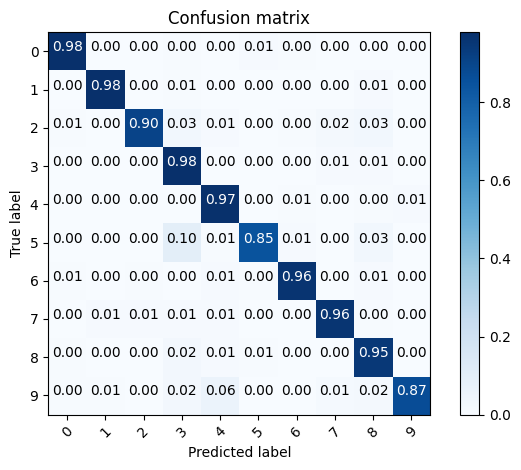

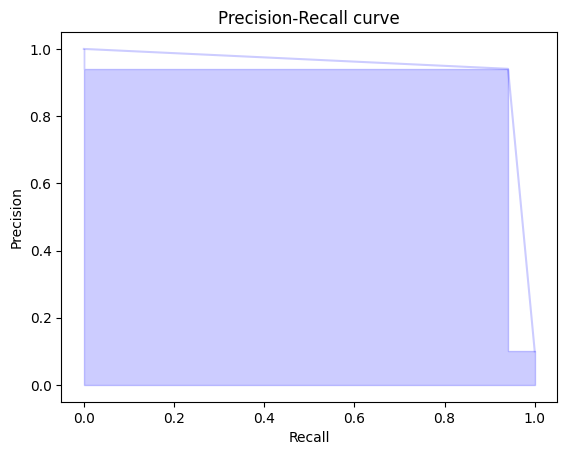

<ipython-input-8-360192ba04ce>:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


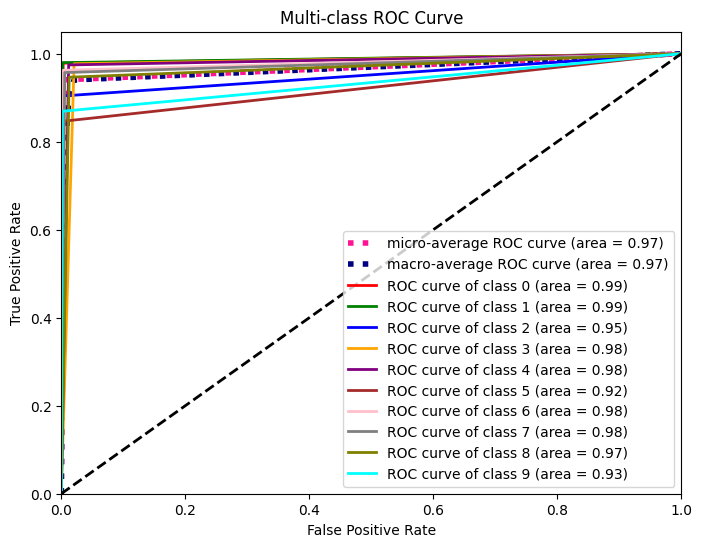

Weighted accuracy with distance 1: 0.9293847680091858


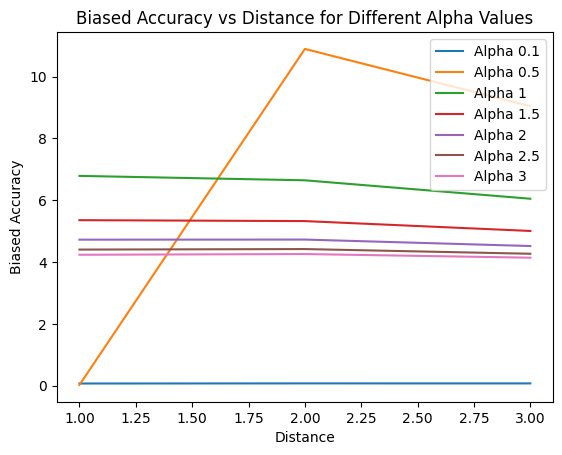

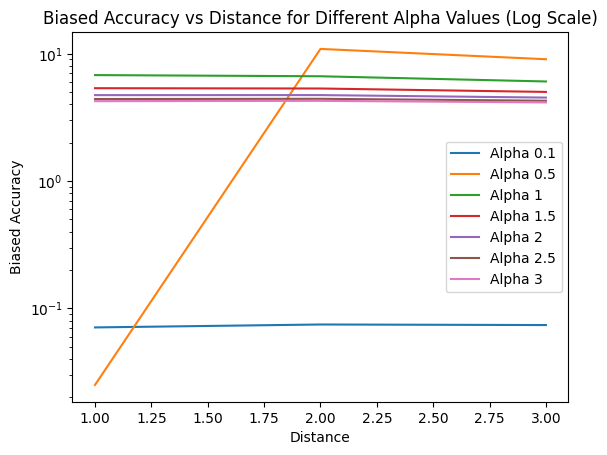

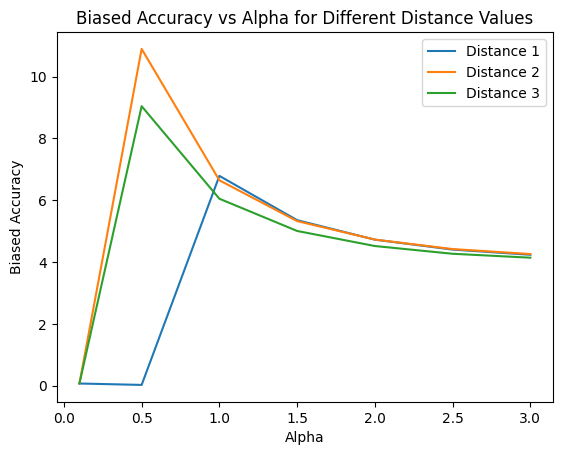

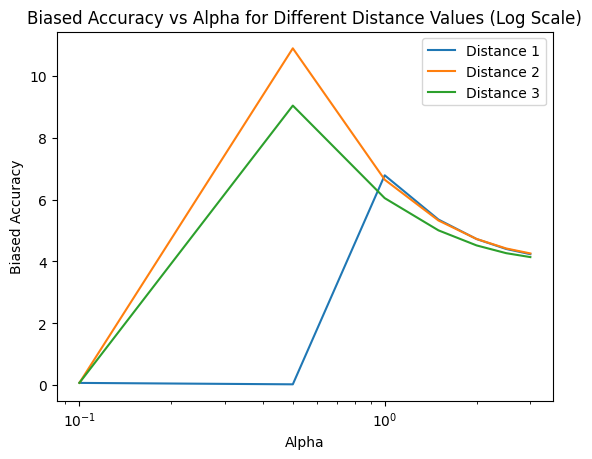

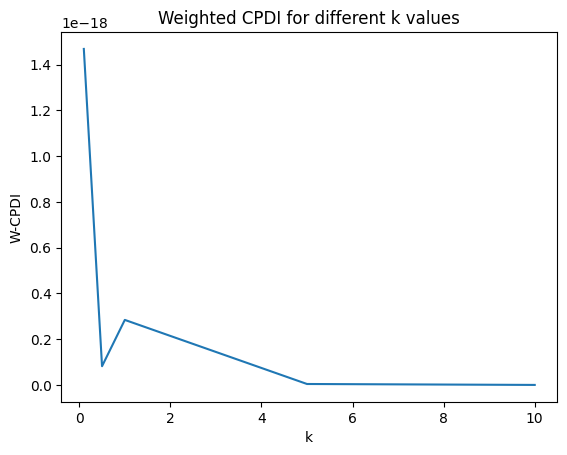

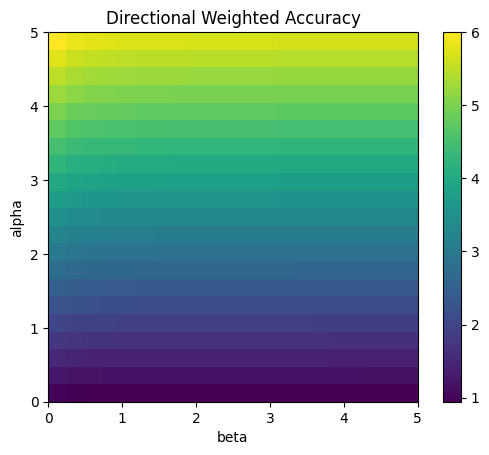

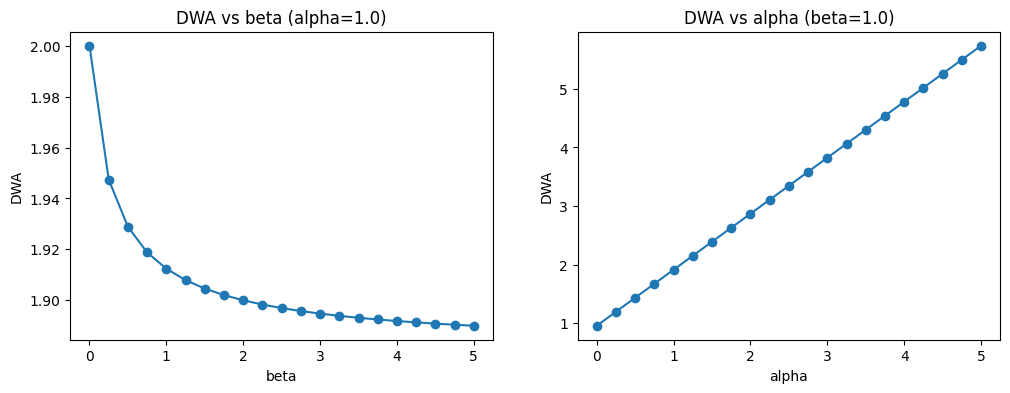

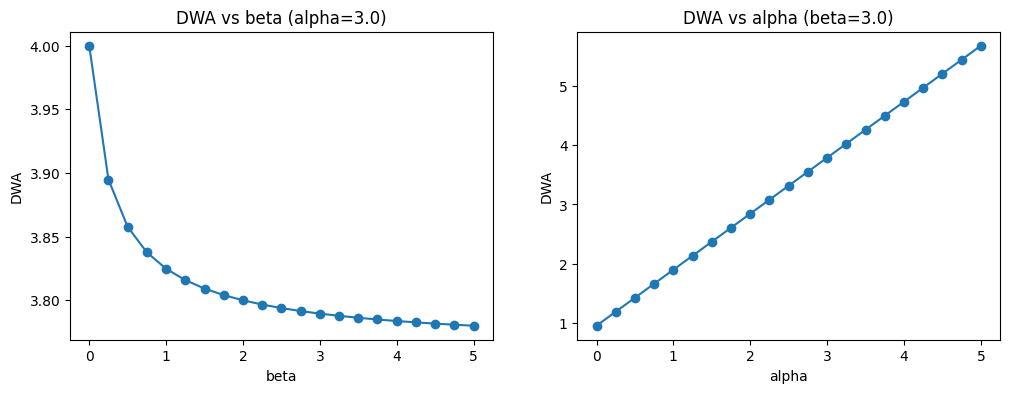

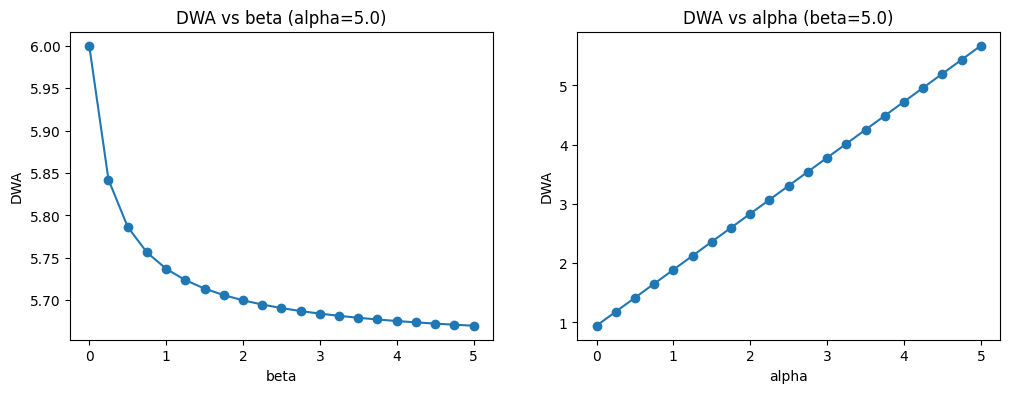

In [ ]:
# Initialize model, optimizer, and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# Move model and data to target device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train(model, train_loader, criterion, optimizer, 1)

# Test the model
test(model, test_loader)
